In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [10]:
# helper functions
def printTable(header, data):
    """
    Prints table with columns of header and data.

    Parameters
    ----------
    header : []
        list of header labels
        ex. header = ["one","two","three"]
    data : [[],[],...,[]]
        list of lists, each inner list is a data line
        data line must index with header appropriately
        ex. data = [[1, 2, 3],[1, 2, 3]]
    """

    # print headers
    col_widths=[]
    for i,label in enumerate(header):
        col_widths.append(len(label))
        if i == 0 :
            print("| ",end="")
        print(str(label).center(len(label)), end=" | ")
    print()

    # print separating line
    for i,width in enumerate(col_widths):
        if i == 0 :
            print("| ",end="")
        print("".center(width,"-"), end=" | ")
    print()

    # print data
    for i,line in enumerate(data):
        for i,value in enumerate(line):
            if i == 0 :
                print("| ",end="")
            print(str(value).center(col_widths[i]), end=" | ")
        print()
        
def read_hand_data(filename):
    # parse json file to features
    data_file_name = '../data/'+filename
    nPoints = 21
    with open(data_file_name) as json_file:
        data = json.load(json_file)

        # matrix to store distance to keypoint 0, each image stored in row
        # column array to store labels

        distance_feature = np.ones((int(data["num_pics"]), nPoints-1))
        label_vector = np.ones((int(data["num_pics"]),1))

        # loop through json to constuct feature array
        for i in range(1, int(data["num_pics"])+1): # use num_pics+1 because range ends at integer before stop value
            label = data["pics"][str(i)]["label"] 
            points = np.array(data["pics"][str(i)]["keypoints"] )

            # label array
            label_vector[i-1] = label
            # feature matrix
            pointZero = points[0] # reference distance from point 0
            for j in range(1,nPoints): # calculate distances for points 1-20
                distance_feature[i-1][j-1] = math.sqrt(np.sum(np.square(points[j] - pointZero)))

    return distance_feature, label_vector

def plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title):
    fig,ax = plt.subplots(len(classes),1)
    plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
    
    for c in classes:
        ax[c].set_title("Class {} vs. Rest".format(c),fontsize=15)
        ax[c].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_svm[:,c], label="svm estimate", color="C1", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_svm[:,c], alpha=0.5, color="C1")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_ls[:,c], label="ls estimate", color="C2", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_ls[:,c], alpha=0.5, color="C2")
        ax[c].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="decision boundary")
        ax[0].legend(bbox_to_anchor=(0.8, 2), loc='right', ncol=1,fontsize=12) # legend
    title = fig.suptitle(title, fontsize=20) # title
    fig.tight_layout() # prevent overlapping
    
def plot_ls_results(b_classes, b_hat, title, label, cutoffs):
    fig,ax = plt.subplots(1,1)
    plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
    c = 0
    ax.scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
    ax.plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
    ax.scatter(range(len(b_classes[:,c])), b_hat[:,c], label=label, color="C2", s=15)
    ax.plot(range(len(b_classes[:,c])), b_hat[:,c], alpha=0.5, color="C2")
    for cutoff in cutoffs:
        ax.plot([0,len(b_classes[:,c])], [cutoff, cutoff], alpha=0.5, linestyle="--", color="k", label="{} cutoff".format(cutoff))
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0)) # legend
    plt.title(title, fontsize=20) # title
    fig.tight_layout() # prevent overlapping

## Least Squares

### Train

In [11]:
# get data
X, b = read_hand_data("data_train.json")

# calculate weights
w_ls = np.linalg.inv(X.T@X)@X.T@b

print("Least Squares Weights:\n", w_ls)
print()
print("Training complete!")

Least Squares Weights:
 [[ 0.0240268 ]
 [-0.00639227]
 [-0.00391932]
 [ 0.00652349]
 [-0.02533702]
 [-0.02475601]
 [ 0.03086521]
 [-0.00775412]
 [ 0.01060814]
 [ 0.02091449]
 [-0.01344233]
 [ 0.00822527]
 [ 0.00363728]
 [-0.0169834 ]
 [ 0.005658  ]
 [ 0.00696864]
 [ 0.00181423]
 [-0.00165621]
 [ 0.00587157]
 [-0.00446516]]

Training complete!


### Test

| class | ls error | 
| ----- | -------- | 
|   0   | 33.33 %  | 
|   1   | 66.67 %  | 
|   2   |  0.00 %  | 
|   3   |  0.00 %  | 
|   4   |  0.00 %  | 
|   5   |  0.00 %  | 


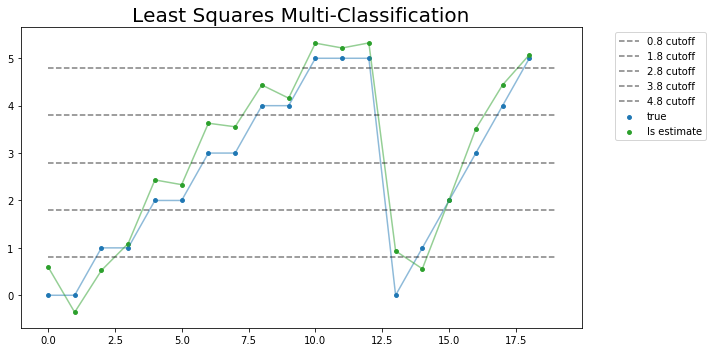

In [12]:
# get data
X_test, b_test = read_hand_data("data_test.json")

# make predictions
b_predict = X_test@w_ls

# round predictions
cutoffs = [0.8, 1.8, 2.8, 3.8, 4.8]
classes = [0, 1 ,2 ,3 ,4 ,5]

def classify(classes, b_hat, cutoffs):
    b_classified = b_hat.copy()
    for i in range(len(b_classified)):
        if b_classified[i] < cutoffs[0]:
            b_classified[i] = classes[0]
        elif b_classified[i] > cutoffs[-1]:
            b_classified[i] = classes[-1]
        else:
            loop = True
            for j in range(0, len(cutoffs)-1):
                if loop and b_classified[i] > cutoffs[j] and b_classified[i] < cutoffs[j+1]:
                    b_classified[i] = classes[j+1]
                    loop = False
        
    return b_classified

# test ls against test data
header = ["class", "ls error"]
data = []

for c in classes:
    # make classification
    b_hat = classify(classes, b_predict[np.where(b_test==c)], cutoffs).reshape(len(b_predict[np.where(b_test==c)]),)

    # find percent incorrect
    num_incorrect_svm = np.sum(b_hat != c)
    percent_incorrect_svm = num_incorrect_svm/len(b_hat)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm)])
    
# print results
printTable(header,data)

# plot
b_plot = b_test.reshape((len(b_test),1))
plt.rcParams['figure.figsize'] = [10, 5] # matplotlib window size = [width, height]
plot_ls_results(b_plot, b_predict, "Least Squares Multi-Classification", "ls estimate", cutoffs)
plt.show()

## One vs. Rest

### Train

In [13]:
# get data
X, b = read_hand_data("data_train.json")

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
w_k = np.zeros((len(X[0])+1, 1))

r = 0.1 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))
descent_done = False

for c in classes:
    # form binary labels
    b_svm = np.where(b == c, 1, -1)
    last_loss = math.inf
    descent_done = False
    iterations = 0

    # train svm
    while not descent_done:
        loss = 0
        l_hinge = np.zeros(w_k.shape)
        # loop through training samples
        for s in range(num_samples):
            # indicator function
            if b_svm[s]*X_svm[s]@w_k <= 1:
                loss += (1-b_svm[s]*X_svm[s]@w_k)
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
        w_tilda = np.copy(w_k)
        w_tilda[-1] = 0
        w_k = w_k - tau*(l_hinge+2*r*w_tilda)
        
        # compare loss to determine if reached minimum
        if(last_loss < loss):
            print("Class {} converged after {} iterations".format(c,iterations))
            descent_done = True
        else:
            # svm weights
            w_tilda = np.copy(w_k)
            w_tilda[-1] = 0
            w_k = w_k - tau*(l_hinge+2*r*w_tilda)

        # update for next iteration
        last_loss = loss
        iterations +=1
        
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))

print("Training complete!")

Class 0 converged after 1165 iterations
Class 1 converged after 1437 iterations
Class 2 converged after 362 iterations
Class 3 converged after 885 iterations
Class 4 converged after 844 iterations
Class 5 converged after 717 iterations
Training complete!


### Test

| class | svm error | least squares error | 
| ----- | --------- | ------------------- | 
|   0   |   0.00 %  |        0.00 %       | 
|   1   |   0.00 %  |        0.00 %       | 
|   2   |   0.00 %  |        0.00 %       | 
|   3   |   0.00 %  |        0.00 %       | 
|   4   |   0.00 %  |        0.00 %       | 
|   5   |   0.00 %  |        0.00 %       | 


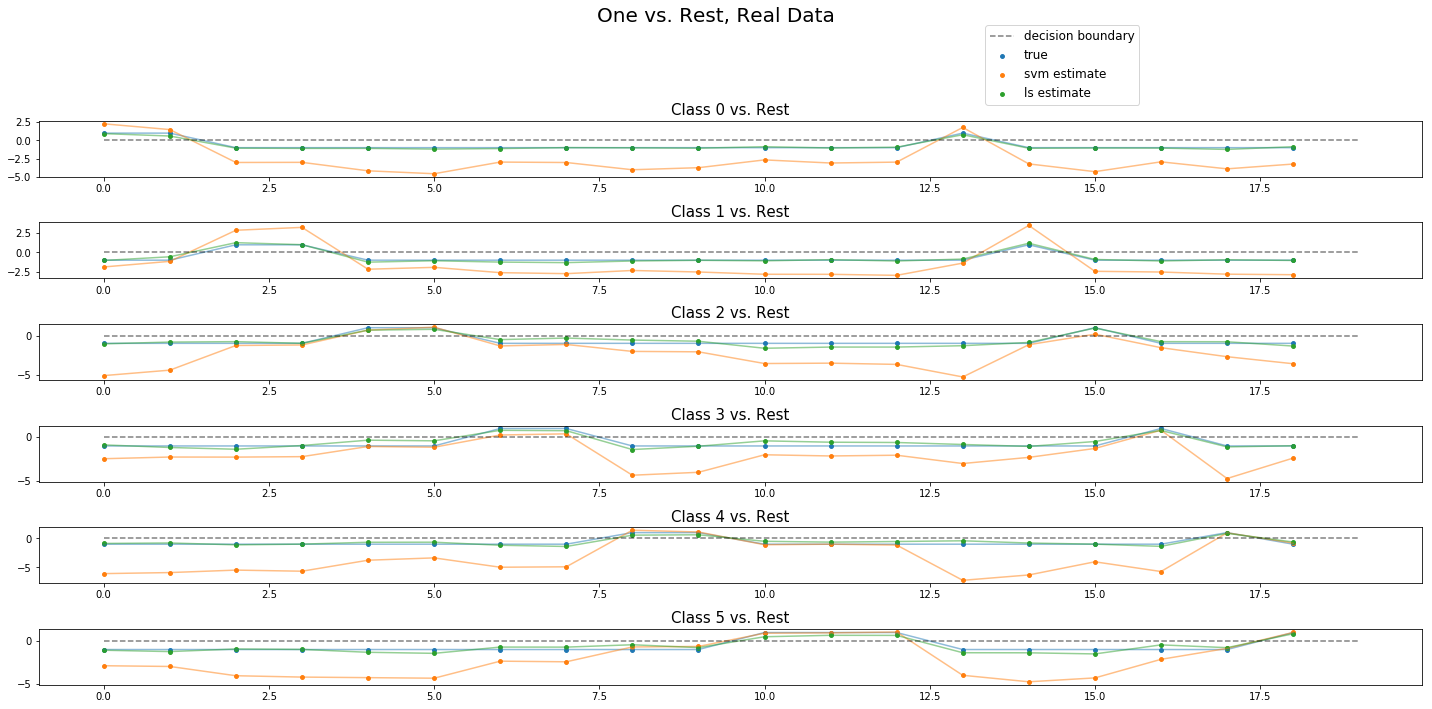

In [14]:
# test svm against new test data
X_test, b_test = read_hand_data("data_test.json")

# format data for svm
num_samples = len(b_test)
X_test = np.hstack((X_test, np.ones((num_samples, 1))))

header = ["class", "svm error", "least squares error"]
data = []

classes = [0,1,2,3,4,5]
b_classes = np.zeros((len(b_test),len(classes)))
b_test = b_test.reshape((len(b_test),))
b_hat_svm = np.zeros(b_classes.shape)
b_hat_ls = np.zeros(b_classes.shape)

for c in classes:
    b_classes[:,c] = np.where(b_test == c, 1, -1)
    b_test_svm = X_test@w_svm[:,c]
    b_test_ls = X_test@w_ls[:,c]
    b_hat_svm[:,c] = b_test_svm.reshape(len(b_test))
    b_hat_ls[:,c] = b_test_ls.reshape(len(b_test))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_hat_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b_test)*100
    num_incorrect_svm = np.sum(np.sign(b_hat_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b_test)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])

# print table
printTable(header,data)

# plot
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
title = "One vs. Rest, Real Data"
plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title)
plt.show()

## One vs. One

### Train

In [15]:
# get data
X, b = read_hand_data("data_train.json")

# model parameters
num_samples = len(b)

r = 0.1 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
w_svm = np.zeros((len(w_k),len(classes)))
weights_classes = []
descent_done = False
    
for i in range(len(classes)):
    for j in range(len(classes)):
        if j>i:
            #create test groups
            g1 = np.where(b == i)[0]
            g2 = np.where(b == j)[0]
            w_k = np.zeros((len(X[0])+1, 1))

            X_class1 = [X_svm[k] for k in g1]
            X_class2 = [X_svm[k] for k in g2]
            X_class = np.vstack((X_class1,X_class2))
            b_class_orig1 = [b[k] for k in g1]
            b_class_orig2 = [b[k] for k in g2]
            b_class_orig = b_class_orig1 + b_class_orig2
            b_svm = np.where(np.asarray(b_class_orig) == i, 1, -1)

            # train svm
            last_loss = 100000000000000.
            descent_done = False
            iterations = 0

            while not descent_done:
                loss = 0
                l_hinge = np.zeros(w_k.shape)
                # loop through training samples
                for s in range(len(b_svm)):
                    # indicator function
                    if b_svm[s]*X_class[s]@w_k <= 1:
                        loss += (1-b_svm[s]*X_class[s]@w_k)
                        l_hinge = np.add(l_hinge, -b_svm[s]*X_class[s].reshape(l_hinge.shape))
    
                # compare loss to determine if reached minimum
                if(last_loss < loss):
                    print("Pair {} vs {} converged after {} iterations".format(i, j, iterations))
                    descent_done = True
                else:
                    # svm weights
                    w_tilda = np.copy(w_k)
                    w_tilda[-1] = 0
                    w_k = w_k - tau*(l_hinge+2*r*w_tilda)

                # update for next iteration
                last_loss = loss
                iterations +=1

            # save weights
            weights_classes.append(w_k.reshape(len(w_k))) # svm
            
print("Training complete!")

Pair 0 vs 1 converged after 1859 iterations
Pair 0 vs 2 converged after 1118 iterations
Pair 0 vs 3 converged after 1320 iterations
Pair 0 vs 4 converged after 678 iterations
Pair 0 vs 5 converged after 954 iterations
Pair 1 vs 2 converged after 1260 iterations
Pair 1 vs 3 converged after 1095 iterations
Pair 1 vs 4 converged after 736 iterations
Pair 1 vs 5 converged after 535 iterations
Pair 2 vs 3 converged after 773 iterations
Pair 2 vs 4 converged after 1125 iterations
Pair 2 vs 5 converged after 415 iterations
Pair 3 vs 4 converged after 754 iterations
Pair 3 vs 5 converged after 1196 iterations
Pair 4 vs 5 converged after 995 iterations
Training complete!


### Test

In [16]:
# test svm against new test data
X_test, b_test = read_hand_data("data_test.json")

# format data for svm
num_samples = len(b_test)
X_test = np.hstack((X_test, np.ones((num_samples, 1))))

# test svm against known training data
header = ["class", "  svm  "]
data = []
num_classes = len(classes)
count_class = np.zeros((num_classes))
count_total = np.zeros((num_classes))
b_test_svm = []

c1 = 0
c2 = 1
num_wrong = 0
counter = 0
a = 0
for x in X_test: 
    count_class = [0]*num_classes
    counter +=1
    for w in range(len(weights_classes)):
        b_hat_svm = x@weights_classes[w]
        
        if b_hat_svm > 0:
            count_class[c1] = count_class[c1] + 1
        elif b_hat_svm < 0:
            count_class[c2] = count_class[c2] + 1
        if c2<len(classes) - 1:
            c2 = c2 + 1
        else:
            c1 = c1 + 1
            c2 = c1 + 1

    c1 = 0
    c2 = 1
    b_test_svm.append(classes[np.argmax(count_class)])
    count_total = count_total + count_class

count_wrong = np.zeros((num_classes))
count_total = np.zeros((num_classes))
error_total = np.zeros((num_classes))
for m in range(len(b_test)):
    if b_test[m] != b_test_svm[m]:
        count_wrong[int(b_test[m][0])] += 1
        num_wrong = num_wrong+1
    count_total[int(b_test[m][0])] =  count_total[int(b_test[m][0])] + 1
    
# find percent incorrect
percent_incorrect_svm = num_wrong/len(b_test)*100

# print out
header = [" class ", "% error"]
error_total = np.divide(count_wrong,count_total)
for c in classes:
    data.append([c, "{:0.2f} %".format(error_total[c]*100)])
data.append(["Avg","{:0.2f} %".format(percent_incorrect_svm)])
printTable(header,data)

|  class  | % error | 
| ------- | ------- | 
|    0    |  0.00 % | 
|    1    |  0.00 % | 
|    2    |  0.00 % | 
|    3    |  0.00 % | 
|    4    |  0.00 % | 
|    5    |  0.00 % | 
|   Avg   |  0.00 % | 
